### Modelo preditivo Bitcoin

- Instalar biblioteca **yfinance**

In [ ]:
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 55.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


- Importar bibliotecas de manipulação de dados

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

- Importar bibliotecas realizar as predições

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
import joblib

- Importar bibliotecas para plotar gráficos

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('ggplot')
%matplotlib inline

- Importar bibliotecas internas do python

In [ ]:
from functools import reduce
from datetime import datetime

- Definir datas para capturar os dados

In [ ]:
date_today = datetime.strftime(datetime.today(), '%Y-%m-%d')
date_init = "2014-01-01"

- Criar funções auxiliares 

In [ ]:
list_tickers = ["BTC-USD"]

def download_tickers(ticker):
  try:
    asset = yf.download(ticker, start=date_init, end=date_today, interval='1d')
    return asset.Close
  except Exception as err:
    print(f"ERROR: {err}")

  
def create_data_frame(asset_close, ticker):
  return pd.DataFrame(asset_close).rename(columns = {'Close': ticker})


def mean_absolute_percentage_error(y_true, y_pred):
	"""Take in true and predicted values and calculate the MAPE score"""
	y_true, y_pred = np.array(y_true), np.array(y_pred)
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

- Download dos dados

In [ ]:
df_btc = yf.download("BTC-USD", date_init, date_today)
df_btc = df_btc.reset_index()

[*********************100%***********************]  1 of 1 completed


- Reindexar index, por default vem o Date

In [ ]:
df_btc.reset_index(inplace=True)

In [ ]:
df_btc.dtypes

index                      int64
Date         datetime64[ns, UTC]
Open                     float64
High                     float64
Low                      float64
Close                    float64
Adj Close                float64
Volume                     int64
dtype: object

- Converter data

In [ ]:
# df_btc["Date"] = df_btc.Date.dt.strftime('%Y-%m-%d')
df_btc['Date'] = pd.to_datetime(df_btc['Date'], format="%Y-%m-%d")

- Criar médias móveis de 7 dias e 21 dias

In [ ]:
df_btc['mm7d'] = df_btc['Adj Close'].rolling(7).mean()
df_btc['mm21d'] = df_btc['Adj Close'].rolling(21).mean()

df_btc.tail()

,index,Date,Open,High,Low,Close,Adj Close,Volume,mm7d,mm21d
2945,2945,2022-10-10 00:00:00+00:00,19446.416016,19515.466797,19102.978516,19141.484375,19141.484375,27425022774,19714.904576,19363.684896
2946,2946,2022-10-11 00:00:00+00:00,19139.000000,19241.960938,18925.603516,19051.417969,19051.417969,28711532910,19531.272321,19371.333891
2947,2947,2022-10-12 00:00:00+00:00,19052.646484,19203.199219,19029.757812,19157.445312,19157.445312,24950173846,19387.947824,19400.383650
2948,2948,2022-10-13 00:00:00+00:00,19156.966797,19453.328125,18319.822266,19382.904297,19382.904297,44219840004,19306.156529,19398.924293
2949,2949,2022-10-14 00:00:00+00:00,19382.533203,19889.146484,19115.408203,19185.656250,19185.656250,38452356727,19254.557478,19393.591797


- Função de agrupamento dos dados

In [ ]:
def group_data(type_group):
  new_df = df_btc.groupby(pd.Grouper(key="Date", freq=type_group)).sum()
  new_df.reset_index(inplace=True)
  return new_df

- Função para plotar grafico conforme o Agrupamento dos Dados
- Tipo de agrupamento:
- Por Meses (M) ou por Semanas (W)
- Por Ano (year)
- Tipo de grafico: 'bar',  'line',  'hist',  'barh'

In [ ]:
def create_plot_custom(filter_Mounth_or_Week, year, type_plot):
  """ 
    Cria um grafico filtrando por Ano, Meses ou Semanas

    filter_Mounth_or_Week: 'M' ou 'W'
    type_plot: 'line', 'bar', 'hist', 'barh'
  
  """
  if year >= 2014 and year <= 2022 and filter_Mounth_or_Week in ("M", "W"):
    filtro_label = None
    df_filter = group_data(filter_Mounth_or_Week)
    include = df_filter[df_filter['Date'].dt.year == year]
    meses = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
    if len(include.index) == 12:
      include.index = meses[:len(include.index)]
      filtro_label = "Meses"
    elif len(include.index) > 50:
      include.index = [i for i in range(0, len(include.index))]
      filtro_label = "Semanas"
    include.plot(y="Adj Close", kind=type_plot, figsize=(14, 8),rot=30, title=f'Distruibuição por {filtro_label} - ano {year}', ylabel='Preço US$', xlabel=filtro_label, color="blue")

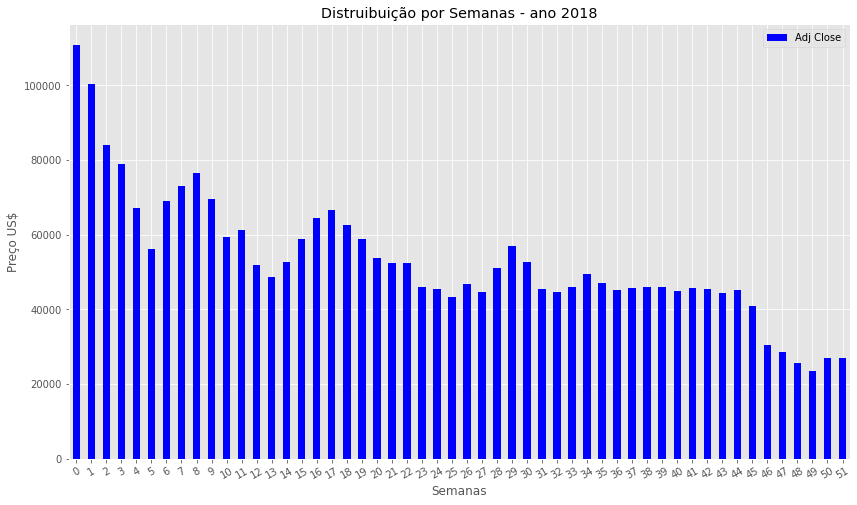

In [ ]:
create_plot_custom("W", 2018, "bar")

- Empurrando para frente os valores da criptomoeda

In [ ]:
df_btc['Adj Close'] = df_btc['Adj Close'].shift(-1)
df_btc.tail()

,index,Date,Open,High,Low,Close,Adj Close,Volume,mm7d,mm21d
2945,2945,2022-10-10 00:00:00+00:00,19446.416016,19515.466797,19102.978516,19141.484375,19051.417969,27425022774,19714.904576,19363.684896
2946,2946,2022-10-11 00:00:00+00:00,19139.000000,19241.960938,18925.603516,19051.417969,19157.445312,28711532910,19531.272321,19371.333891
2947,2947,2022-10-12 00:00:00+00:00,19052.646484,19203.199219,19029.757812,19157.445312,19382.904297,24950173846,19387.947824,19400.383650
2948,2948,2022-10-13 00:00:00+00:00,19156.966797,19453.328125,18319.822266,19382.904297,19185.656250,44219840004,19306.156529,19398.924293
2949,2949,2022-10-14 00:00:00+00:00,19382.533203,19889.146484,19115.408203,19185.656250,NaN,38452356727,19254.557478,19393.591797


- Remover os dados nulos

In [ ]:
df_btc.dropna(inplace=True)
df_btc

,level_0,index,Date,Open,High,Low,Close,Adj Close,Volume,mm7d,mm21d
0,20,20,2014-10-07 00:00:00+00:00,330.584015,339.247009,320.481995,336.187012,352.940002,49199900,347.691572,387.352142
1,21,21,2014-10-08 00:00:00+00:00,336.115997,354.364014,327.187988,352.940002,365.026001,54736300,343.309431,382.380999
2,22,22,2014-10-09 00:00:00+00:00,352.747986,382.726013,347.687012,365.026001,361.562012,83641104,341.874289,379.551761
3,23,23,2014-10-10 00:00:00+00:00,364.687012,375.066986,352.963013,361.562012,362.299011,43665700,342.167149,377.969190
4,24,24,2014-10-11 00:00:00+00:00,361.362000,367.191010,355.950989,362.299011,378.549011,13345200,346.943294,375.749906
...,...,...,...,...,...,...,...,...,...,...,...
2924,2944,2944,2022-10-09 00:00:00+00:00,19417.478516,19542.539062,19349.259766,19446.425781,19141.484375,16837262532,19783.775391,19382.858445
2925,2945,2945,2022-10-10 00:00:00+00:00,19446.416016,19515.466797,19102.978516,19141.484375,19051.417969,27425022774,19714.904576,19363.684896
2926,2946,2946,2022-10-11 00:00:00+00:00,19139.000000,19241.960938,18925.603516,19051.417969,19157.445312,28711532910,19531.272321,19371.333891
2927,2947,2947,2022-10-12 00:00:00+00:00,19052.646484,19203.199219,19029.757812,19157.445312,19382.904297,24950173846,19387.947824,19400.383650


- Testar se o DataFrame possui dados nulos

In [ ]:
assert df_btc.isnull().sum().sum() == 0

- Separar os dados em Treino, Teste e Validação. 

In [ ]:
qtd_linhas = len(df_btc)

qtd_linhas_treino= round(.70 * qtd_linhas)
qtd_linhas_teste= qtd_linhas - qtd_linhas_treino  
qtd_linhas_validacao = qtd_linhas -1

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1}"
    f" linhas validação= {qtd_linhas_validacao}"
)

info

'linhas treino= 0:2050 linhas teste= 2050:2928 linhas validação= 2928'

- Separar a **labels** que será o target a ser encontrado pelo modelo preditivo
- Separar as **features** que serão utilizadas para prever o valor final

In [ ]:
features = df_btc.drop(['Date', 'Adj Close'], 1)
labels = df_btc['Adj Close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


- Escolhendo as melhores features com Kbest

In [ ]:
features_list = ('Date', 'Open', 'High', 'Low', 'Volume', 'mm7d', 'mm21d')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()

print ("\nMelhores features:")
print (k_best_features_final)


Melhores features:
{'mm21d': 9404.323430992825, 'Volume': 7300.963518235119, 'mm7d': 6272.112825122737, 'Low': 4717.323769379292, 'High': 3561.678916528469, 'Open': 3561.678916528469}


- Separando as features escolhidas, com melhor pontuação

In [ ]:

features = df_btc.loc[:,['mm7d','mm21d', 'Volume', 'High', 'Low']]
features

,mm7d,mm21d,Volume,High,Low
0,347.691572,387.352142,49199900,339.247009,320.481995
1,343.309431,382.380999,54736300,354.364014,327.187988
2,341.874289,379.551761,83641104,382.726013,347.687012
3,342.167149,377.969190,43665700,375.066986,352.963013
4,346.943294,375.749906,13345200,367.191010,355.950989
...,...,...,...,...,...
2924,19783.775391,19382.858445,16837262532,19542.539062,19349.259766
2925,19714.904576,19363.684896,27425022774,19515.466797,19102.978516
2926,19531.272321,19371.333891,28711532910,19241.960938,18925.603516
2927,19387.947824,19400.383650,24950173846,19203.199219,19029.757812


- Criando Pipeline

In [ ]:
pipeline_linear_regression = make_pipeline(MinMaxScaler(), LinearRegression())

- Separa os dados de treino teste e validação

In [ ]:

X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

2050 2050
878 878


- Treina modelo

In [ ]:
pipeline_linear_regression.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

- Confere 

In [ ]:
score_model = pipeline_linear_regression.score(X_test, y_test)
f'Teste pontuação para avaliar a consistência do modelo: {score_model * 100:.2f}%'

'Teste pontuação para avaliar a consistência do modelo: 99.07%'

- Pega último dado do dataframe

In [ ]:
data_pred = ['mm7d','mm21d', 'Volume', 'High', 'Low']
df_btc.tail(1)

,level_0,index,Date,Open,High,Low,Close,Adj Close,Volume,mm7d,mm21d
2928,2948,2948,2022-10-13 00:00:00+00:00,19156.966797,19453.328125,18319.822266,19382.904297,19185.65625,44219840004,19306.156529,19398.924293


- Testar a predição

In [ ]:
pipeline_linear_regression.predict(df_btc.tail(1)[data_pred])

array([18855.22323785])

- Realizar a predição com os dados de testes(dados que o modelo desconhece)

In [ ]:
previsao = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

data_btc_full=df_btc["Date"]
data_btc = data_btc_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

res_full = df_btc["Adj Close"]
res = res_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]


predict2 = pipeline_linear_regression.predict(previsao)


df = pd.DataFrame({ "data_bitcoin": data_btc, "real": res , "previsao": predict2 })

df["real"] = df["real"].shift(+1)

df.set_index("data_bitcoin", inplace= True)

df.tail()



,real,previsao
data_bitcoin,,
2022-10-08 00:00:00+00:00,19416.568359,19371.502108
2022-10-09 00:00:00+00:00,19446.425781,19355.059770
2022-10-10 00:00:00+00:00,19141.484375,19229.777671
2022-10-11 00:00:00+00:00,19051.417969,18994.322184
2022-10-12 00:00:00+00:00,19157.445312,19030.354088


- Plotar os resultados

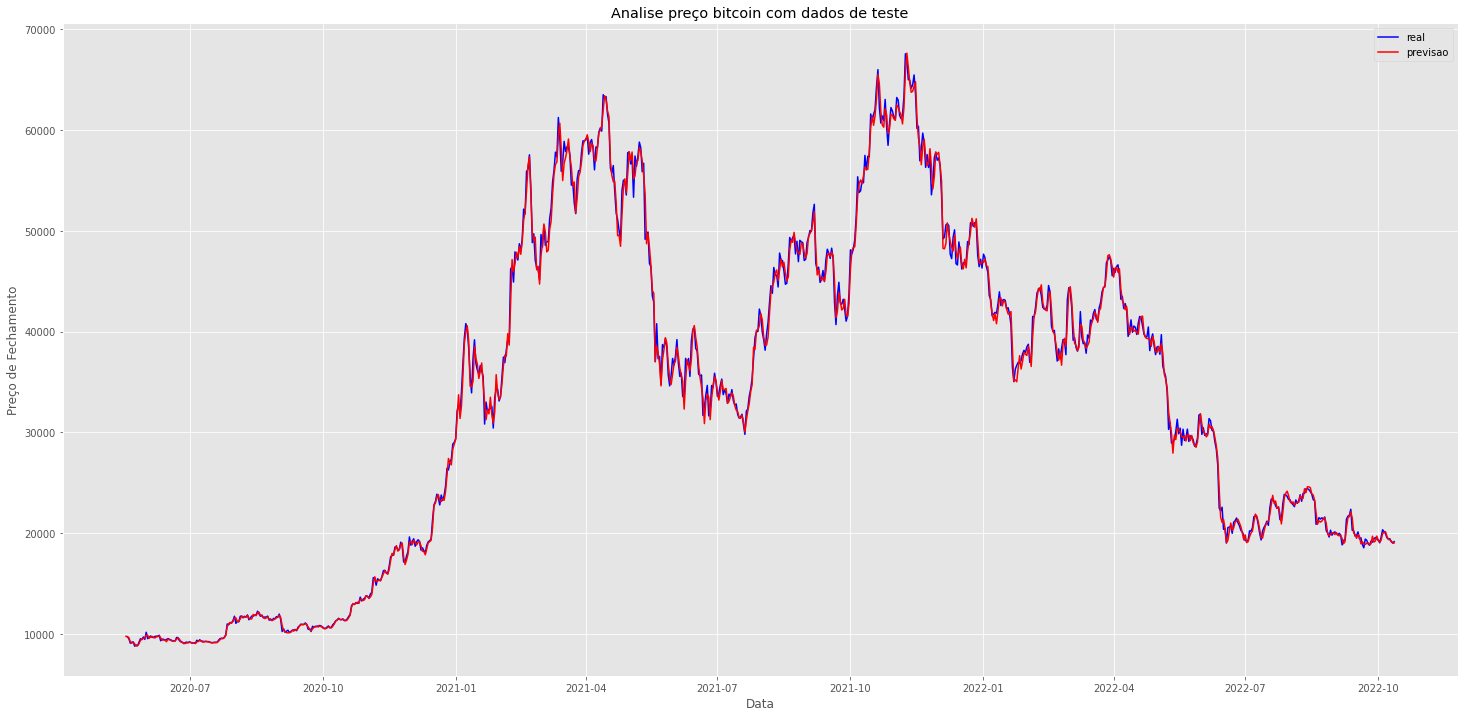

In [ ]:
plt.figure(figsize=(25,12))
plt.title("Analise preço bitcoin com dados de teste")
plt.plot(df["real"], label="real", color="blue")
plt.plot(df["previsao"], label="previsao", color="red")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
leg = plt.legend()

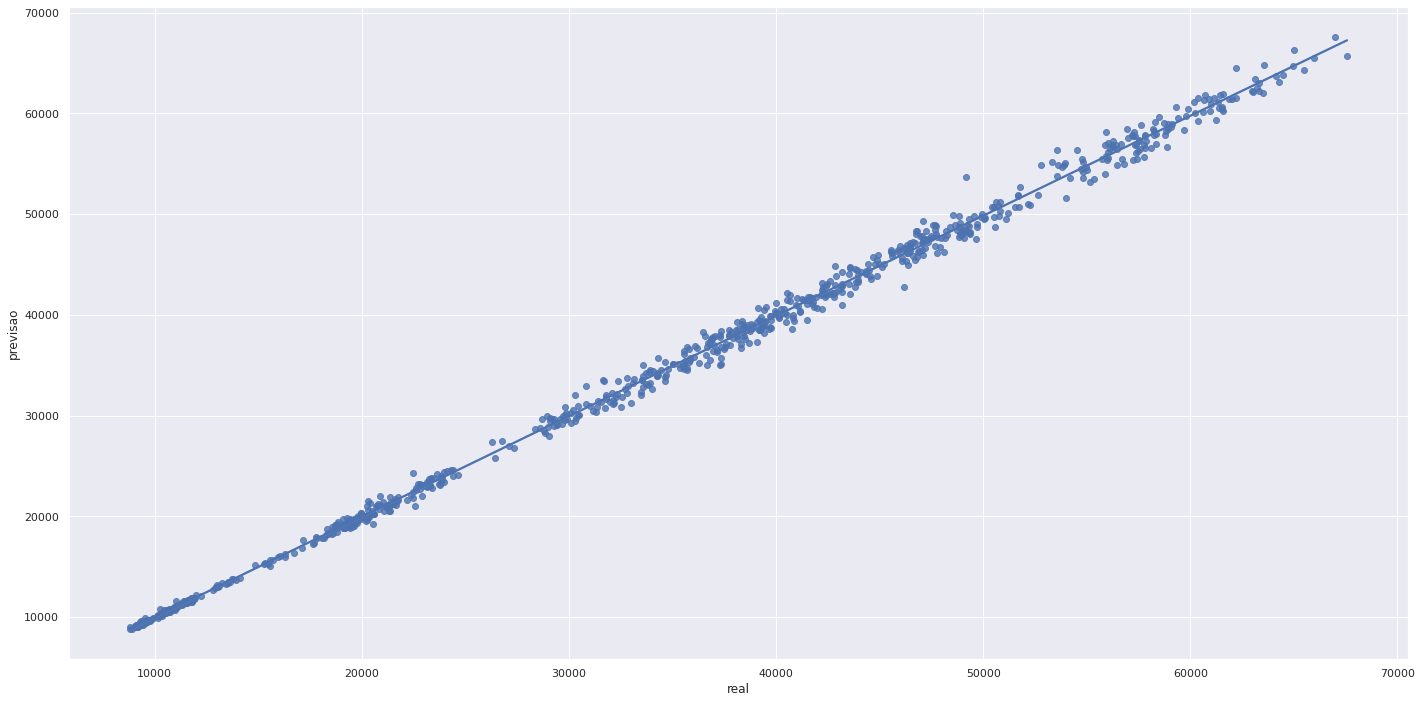

In [ ]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(24, 12)})
sns.regplot(x ="real", y ="previsao", data = df, ci=False, order=2)

- Export modelo preditivo 

In [ ]:
joblib.dump(pipeline_linear_regression, 'pipeline_linear_regression.pk1')

['pipeline_linear_regression.pk1']

- Import modelo preditivo

In [ ]:
model = joblib.load('pipeline_linear_regression.pkl')